In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate, Input, BatchNormalization, Reshape
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Import the data
input_path = "/kaggle/input/infrasound5/input.json"
labels_path = "/kaggle/input/infrasound5/labels.json"

data = (pd.read_json(input_path)).values

atmo_input = np.array([np.array(d[0]) for d in data])
fft_input = np.array([np.array(d[1]) for d in data])

print(atmo_input.shape)
print(fft_input.shape)

labels = (pd.read_json(labels_path)).values
labels_output = np.array(labels)
altitude_output = np.array([sublist[0] for sublist in labels_output])
distance_output = np.array([sublist[1] for sublist in labels_output])

print(labels_output.shape)

#Split into train, val, test
atmo_train, atmo_val, fft_train, fft_val, altitude_train, altitude_val, distance_train, distance_val = train_test_split(atmo_input, fft_input, altitude_output, distance_output, test_size=0.2, random_state=42)

(87348, 51)
(87348, 4096)
(87348, 2)


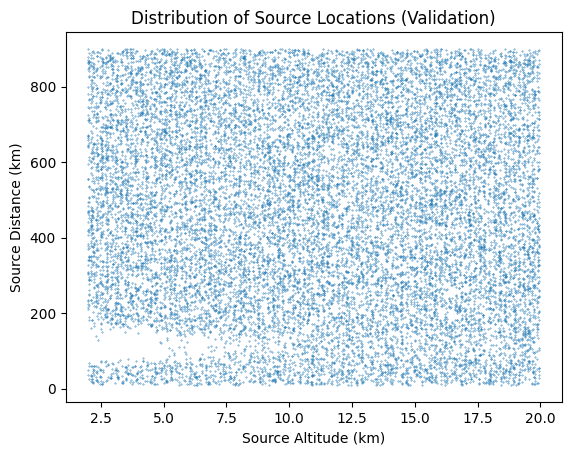

In [11]:
# observe the distribution of the data
# 0-1 scale for visualization purposes

#scaler = MinMaxScaler()
#scaled_labels = scaler.fit_transform(labels_output)
x = altitude_val
y = distance_val
plt.scatter(x, y, s=0.10)
plt.xlabel("Source Altitude (km)")
plt.ylabel("Source Distance (km)")
plt.title("Distribution of Source Locations (Validation)")
plt.savefig("Data Distribution Validation.svg")
plt.show()

**Distance**

In [6]:
#atmostats input model
atmoInput = Input(shape = (51, 1))
x = atmoInput

atmostatsOutput = Flatten()(x)

#fft input model
fftInput = Input(shape = (4096, 1))
y = fftInput

numLayersFFT = 3
for i in range(0, numLayersFFT):
    y = Conv1D(64, kernel_size=4, strides = 1, activation='relu')(y)
    y = MaxPooling1D(pool_size=(8))(y)

fftOutput = Flatten()(y)

#concatenate, feed through another DNN
concatenatedInput = concatenate([atmostatsOutput, fftOutput])
z = concatenatedInput

numLayersFinal = 4
for i in range(0, numLayersFinal):
    z = Dense(64, activation='relu')(z)

#final output layer
output = Dense(1)(z)

#model compilation
model1 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model1.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4093, 64)             320       ['input_2[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 511, 64)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 508, 64)              16448     ['max_pooling1d[0][0]']   

In [7]:
numEpochs = 200
size = 64

history1 = model1.fit(
    [atmo_train, fft_train], distance_train,
    validation_data=([atmo_val, fft_val], distance_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model1.save("src_distance.h5")

Epoch 1/200
1092/1092 [==============================] - 19s 15ms/step - loss: 17767.9727 - mean_absolute_error: 97.0012 - val_loss: 10709.5156 - val_mean_absolute_error: 72.5414
Epoch 2/200
1092/1092 [==============================] - 15s 14ms/step - loss: 9196.8896 - mean_absolute_error: 68.3517 - val_loss: 8212.6885 - val_mean_absolute_error: 62.0240
Epoch 3/200
1092/1092 [==============================] - 15s 14ms/step - loss: 7840.6597 - mean_absolute_error: 61.5765 - val_loss: 7222.7588 - val_mean_absolute_error: 57.9053
Epoch 4/200
1092/1092 [==============================] - 15s 14ms/step - loss: 7186.6128 - mean_absolute_error: 58.1580 - val_loss: 6594.6621 - val_mean_absolute_error: 52.8492
Epoch 5/200
1092/1092 [==============================] - 15s 14ms/step - loss: 6718.5400 - mean_absolute_error: 55.3244 - val_loss: 6881.9102 - val_mean_absolute_error: 55.3782
Epoch 6/200
1092/1092 [==============================] - 15s 14ms/step - loss: 6390.8960 - mean_absolute_error: 5

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


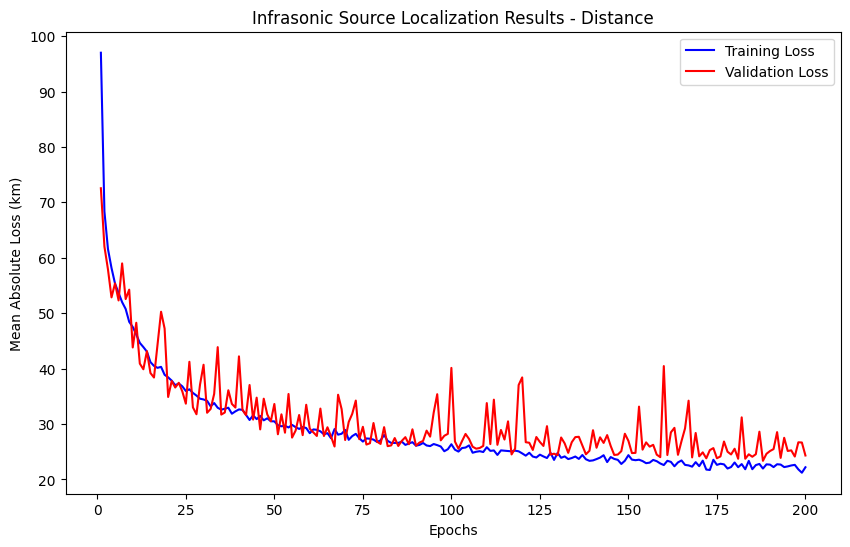

In [9]:
# Extract loss values
train_loss = history1.history['mean_absolute_error']
val_loss = history1.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Distance')
plt.legend()

plt.savefig("Normal_Model_Distances.png")

plt.show()

In [10]:
pd.DataFrame(train_loss).to_csv("distance_train_loss")
pd.DataFrame(val_loss).to_csv("distance_val_loss")

In [3]:
model1 = keras.models.load_model('/kaggle/input/distance/tensorflow2/distance/1/Distance_Model_Normal.h5')

In [4]:
valDistPredictions = model1.predict([atmo_val, fft_val]).flatten()
print(valDistPredictions)

546/546 [==============================] - 3s 4ms/step
[ 34.480556  65.63343  584.9888   ... 525.1672   658.8271   447.87164 ]


24.31639556844588
14.29863998413083
649.8989343261719


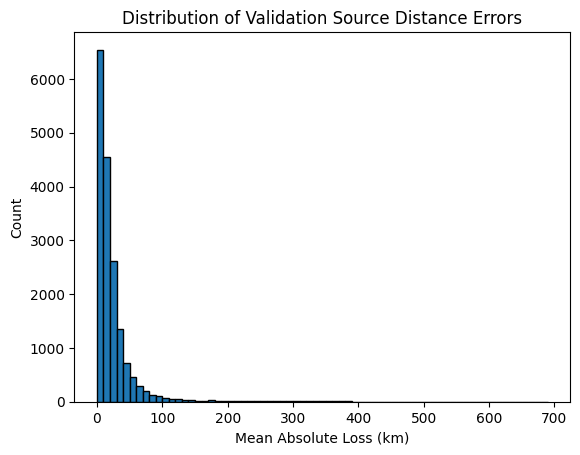

In [5]:
mae_per_sample = np.abs(valDistPredictions - distance_val)
print(np.mean(mae_per_sample))
print(np.median(mae_per_sample))
print(np.max(mae_per_sample))
plt.hist(mae_per_sample, bins=np.arange(0, 700, 10), edgecolor='black')
plt.xlabel("Mean Absolute Loss (km)")
plt.ylabel("Count")
plt.title("Distribution of Validation Source Distance Errors")
plt.savefig("Distance_Error_Distrib.svg")

In [43]:
normalized_mae_per_sample = Normalize(vmin=mae_per_sample.min(), vmax=mae_per_sample.max())

/tmp/ipykernel_26/549063790.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


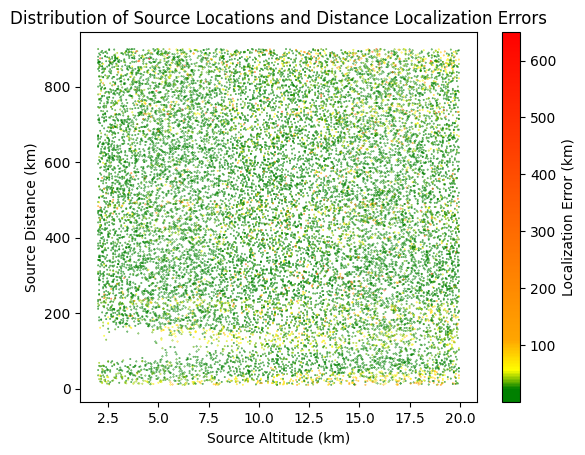

In [48]:
# Define custom colormap
colors = [
    (0.0, "green"),     # 0
    (20/600, "green"),  # 25
    (50/600, "yellow"),  # 100
    (100/600, "orange"),  # 200
    (1.0, "red")       # 600
]

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Create a scatter plot with the color scale
plt.scatter(altitude_val, distance_val, c=mae_per_sample, cmap=custom_cmap, s=0.10)

# Add color bar
sm = ScalarMappable(cmap=custom_cmap, norm=normalized_mae_per_sample)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)
cbar.set_label('Localization Error (km)')

# Add labels and title
plt.xlabel("Source Altitude (km)")
plt.ylabel("Source Distance (km)")
plt.title("Distribution of Source Locations and Distance Localization Errors")
plt.savefig("Location_Error_Distributions_Distance_Model_Edited_ColorBar.svg")
plt.show()

**Altitude**

In [13]:
#model compilation
model2 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4093, 64)             320       ['input_2[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 511, 64)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 508, 64)              16448     ['max_pooling1d[0][0]'] 

In [14]:
history2 = model2.fit(
    [atmo_train, fft_train], altitude_train,
    validation_data=([atmo_val, fft_val], altitude_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model2.save("src_altitude.h5")

Epoch 1/200
1092/1092 [==============================] - 17s 15ms/step - loss: 2507.9917 - mean_absolute_error: 11.7385 - val_loss: 24.6534 - val_mean_absolute_error: 4.1498
Epoch 2/200
1092/1092 [==============================] - 15s 14ms/step - loss: 22.3753 - mean_absolute_error: 3.9321 - val_loss: 20.5735 - val_mean_absolute_error: 3.7532
Epoch 3/200
1092/1092 [==============================] - 15s 14ms/step - loss: 18.7477 - mean_absolute_error: 3.5338 - val_loss: 17.1246 - val_mean_absolute_error: 3.3600
Epoch 4/200
1092/1092 [==============================] - 15s 14ms/step - loss: 17.0125 - mean_absolute_error: 3.3325 - val_loss: 16.7045 - val_mean_absolute_error: 3.2829
Epoch 5/200
1092/1092 [==============================] - 15s 14ms/step - loss: 16.2096 - mean_absolute_error: 3.2417 - val_loss: 15.7077 - val_mean_absolute_error: 3.1707
Epoch 6/200
1092/1092 [==============================] - 15s 14ms/step - loss: 15.6784 - mean_absolute_error: 3.1802 - val_loss: 15.3589 - val

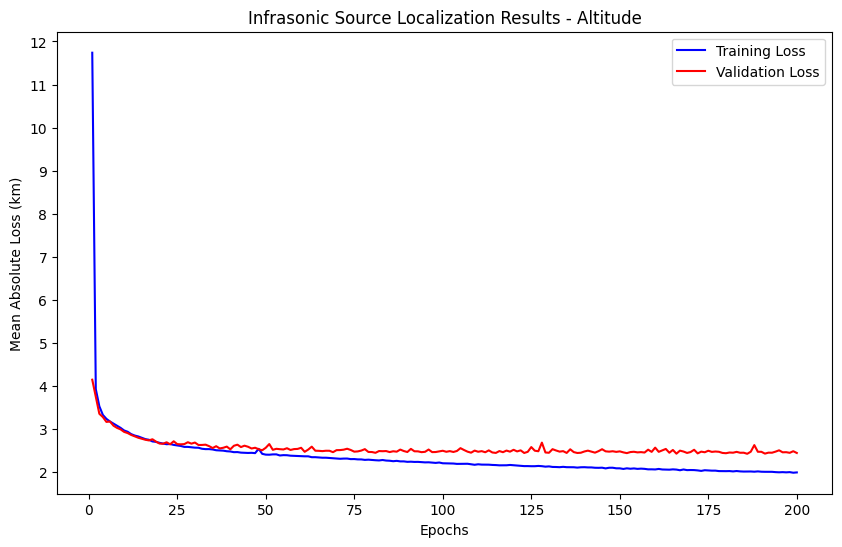

In [18]:
# Extract loss values
train_loss2 = history2.history['mean_absolute_error']
val_loss2 = history2.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss2) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss2, 'b-', label='Training Loss')
plt.plot(epochs, val_loss2, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
y_ticks = np.arange(2, 12.1, 1)  # Change the step size as needed
plt.yticks(y_ticks)
plt.title('Infrasonic Source Localization Results - Altitude')
plt.legend()

plt.savefig("Normal_Model_Altitude.png")

plt.show()

In [25]:
pd.DataFrame(train_loss2).to_csv("altitude_train_loss")
pd.DataFrame(val_loss2).to_csv("altitude_val_loss")

In [3]:
model2 = keras.models.load_model('/kaggle/input/altitude/tensorflow2/altitude/1/Altitude_Model_Normal.h5')

In [4]:
valAltPredictions = model2.predict([atmo_val, fft_val]).flatten()
print(valAltPredictions)

546/546 [==============================] - 3s 3ms/step
[15.478054  13.783186   3.4206038 ... 18.583893   9.893698  14.305004 ]


2.449785037829525
1.8564563751220702
16.70800838470459


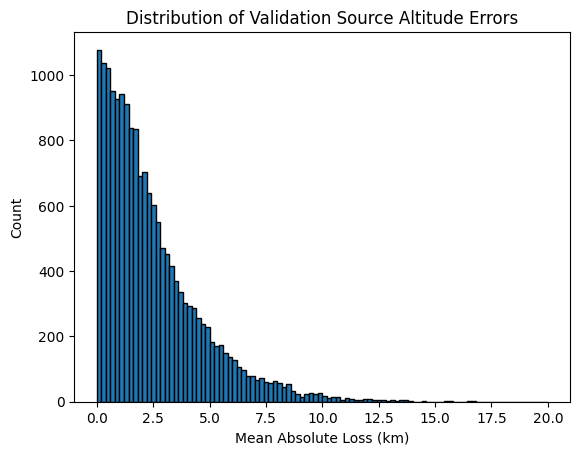

In [5]:
mae_per_sample = np.abs(valAltPredictions - altitude_val)
print(np.mean(mae_per_sample))
print(np.median(mae_per_sample))
print(np.max(mae_per_sample))
plt.hist(mae_per_sample, bins=np.arange(0, 20.2, 0.2), edgecolor='black')
plt.xlabel("Mean Absolute Loss (km)")
plt.ylabel("Count")
plt.title("Distribution of Validation Source Altitude Errors")
plt.savefig("Altitude_Error_Distrib.svg")

In [11]:
normalized_mae_per_sample = Normalize(vmin=mae_per_sample.min(), vmax=mae_per_sample.max())

/tmp/ipykernel_83/3950481945.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


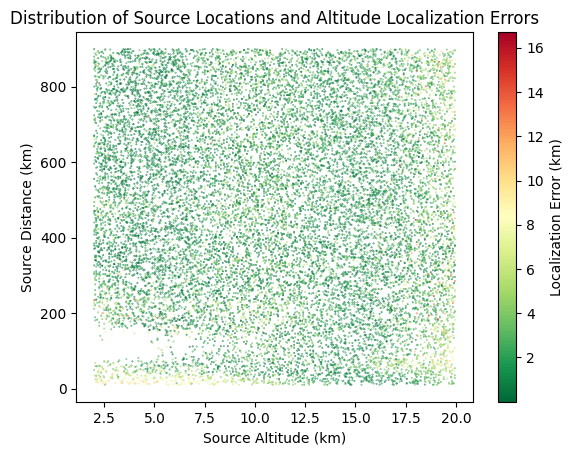

In [12]:
# Choose a colormap
cmap = plt.get_cmap('RdYlGn_r')  # Red for high error, green for low error

# Create a scatter plot with the color scale
plt.scatter(altitude_val, distance_val, c=mae_per_sample, cmap=cmap, s=0.10)

# Add color bar
sm = ScalarMappable(cmap=cmap, norm=normalized_mae_per_sample)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)
cbar.set_label('Localization Error (km)')

# Add labels and title
plt.xlabel("Source Altitude (km)")
plt.ylabel("Source Distance (km)")
plt.title("Distribution of Source Locations and Altitude Localization Errors")
plt.savefig("Location_Error_Distributions_Altitude_Model.svg")
plt.show()

**Ablations for Distance**

In [3]:
#fft input model
fftInput = Input(shape = (4096, 1))
y = fftInput

numLayersFFT = 3
for i in range(0, numLayersFFT):
    y = Conv1D(64, kernel_size=4, padding='same', strides = 1, activation='relu')(y)
    y = MaxPooling1D(pool_size=(8))(y)

fftOutput = Flatten()(y)

numLayersFinal = 4
for i in range(0, numLayersFinal):
    y = Dense(64, activation='relu')(y)

#final output layer
output = Dense(1)(y)

#model compilation
model3 = Model(inputs=fftInput, outputs=output)

opt = Adam(learning_rate=0.001)
model3.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4093, 64)          320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 511, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 508, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 64)            16448 

In [4]:
numEpochs = 100
size = 64

history3 = model3.fit(
    fft_train, distance_train,
    validation_data=(fft_val, distance_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model3.save("distance_model_fft_only.h5")

Epoch 1/100
1092/1092 [==============================] - 25s 17ms/step - loss: 74853.4688 - mean_absolute_error: 229.8622 - val_loss: 65512.8828 - val_mean_absolute_error: 219.4782
Epoch 2/100
1092/1092 [==============================] - 18s 16ms/step - loss: 64297.0664 - mean_absolute_error: 217.7018 - val_loss: 65059.1250 - val_mean_absolute_error: 219.4149
Epoch 3/100
1092/1092 [==============================] - 18s 16ms/step - loss: 64304.8438 - mean_absolute_error: 217.7590 - val_loss: 64834.7344 - val_mean_absolute_error: 219.1132
Epoch 4/100
1092/1092 [==============================] - 18s 16ms/step - loss: 64357.2383 - mean_absolute_error: 217.7470 - val_loss: 65592.3984 - val_mean_absolute_error: 220.1084
Epoch 5/100
1092/1092 [==============================] - 18s 16ms/step - loss: 64333.4844 - mean_absolute_error: 217.7419 - val_loss: 64150.5000 - val_mean_absolute_error: 218.0529
Epoch 6/100
1092/1092 [==============================] - 18s 16ms/step - loss: 64163.0273 - mea

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


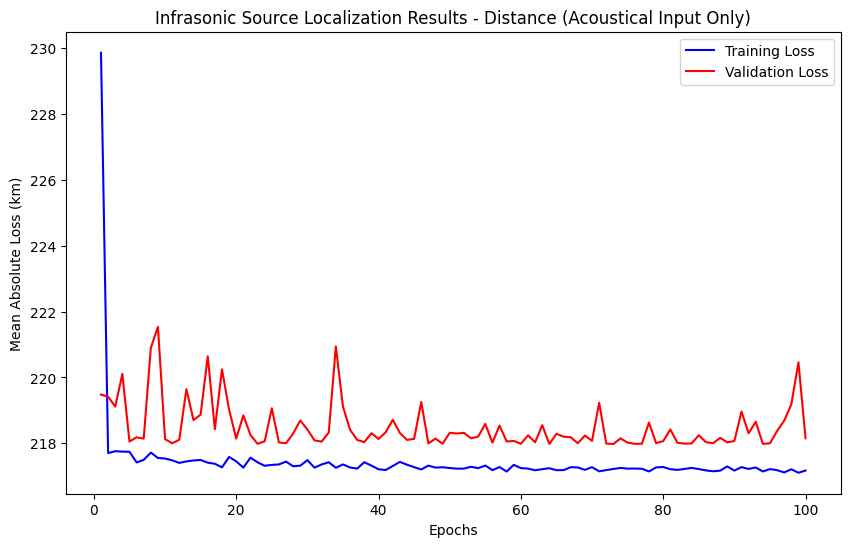

In [7]:
# Extract loss values
train_loss3 = history3.history['mean_absolute_error']
val_loss3 = history3.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss3) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss3, 'b-', label='Training Loss')
plt.plot(epochs, val_loss3, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Distance (Acoustical Input Only)')
plt.legend()

plt.savefig("Ablated_Model_Distance_FFT_Only.png")

plt.show()

In [9]:
pd.DataFrame(train_loss3).to_csv("ablated_distance_fftonly_train_loss")
pd.DataFrame(val_loss3).to_csv("ablated_distance_fftonly_val_loss")

**Ablation for Altitude**

In [9]:
#atmo only model

atmoInput = Input(shape = (51, 1))
x = atmoInput

numLayersFinal = 8
for i in range(0, numLayersFinal):
    x = Dense(64, activation='relu')(x)

#final output layer
output = Dense(1)(x)

#model compilation
model4 = Model(inputs=atmoInput, outputs=output)

opt = Adam(learning_rate=0.001)
model4.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 51, 1)]           0         
                                                                 
 dense_18 (Dense)            (None, 51, 64)            128       
                                                                 
 dense_19 (Dense)            (None, 51, 64)            4160      
                                                                 
 dense_20 (Dense)            (None, 51, 64)            4160      
                                                                 
 dense_21 (Dense)            (None, 51, 64)            4160      
                                                                 
 dense_22 (Dense)            (None, 51, 64)            4160      
                                                                 
 dense_23 (Dense)            (None, 51, 64)            4160

In [10]:
numEpochs = 100
size = 64

history4 = model4.fit(
    atmo_train, altitude_train,
    validation_data=(atmo_val, altitude_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model4.save("altitude_model_atmo_only.h5")

Epoch 1/100
1092/1092 [==============================] - 9s 7ms/step - loss: 32.9050 - mean_absolute_error: 4.8059 - val_loss: 26.8626 - val_mean_absolute_error: 4.4788
Epoch 2/100
1092/1092 [==============================] - 8s 7ms/step - loss: 26.8606 - mean_absolute_error: 4.4753 - val_loss: 26.8046 - val_mean_absolute_error: 4.4749
Epoch 3/100
1092/1092 [==============================] - 8s 7ms/step - loss: 26.8188 - mean_absolute_error: 4.4732 - val_loss: 26.7722 - val_mean_absolute_error: 4.4711
Epoch 4/100
1092/1092 [==============================] - 8s 7ms/step - loss: 26.8156 - mean_absolute_error: 4.4732 - val_loss: 27.0746 - val_mean_absolute_error: 4.4848
Epoch 5/100
1092/1092 [==============================] - 8s 7ms/step - loss: 26.7592 - mean_absolute_error: 4.4688 - val_loss: 27.1990 - val_mean_absolute_error: 4.4912
Epoch 6/100
1092/1092 [==============================] - 8s 7ms/step - loss: 26.8028 - mean_absolute_error: 4.4704 - val_loss: 26.8369 - val_mean_absolute_

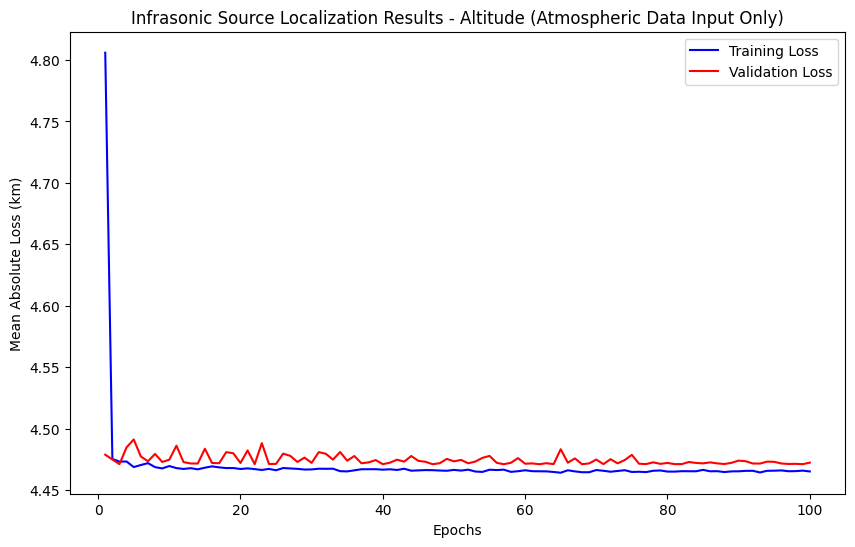

In [11]:
# Extract loss values
train_loss4 = history4.history['mean_absolute_error']
val_loss4 = history4.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss4) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss4, 'b-', label='Training Loss')
plt.plot(epochs, val_loss4, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Altitude (Atmospheric Data Input Only)')
plt.legend()

plt.savefig("Ablated_Model_Altitude_Atmo_Only.png")

plt.show()

**Max Pool Utility Analysis**

In [4]:
# Model with no max pool layer (in response to concerns raised by Ferguson et al 2016, 2017 (ICASSP))

#atmostats input model
atmoInput = Input(shape = (51, 1))
x = atmoInput

atmostatsOutput = Flatten()(x)

#fft input model
fftInput = Input(shape = (4096, 1))
y = fftInput

numLayersFFT = 3
for i in range(0, numLayersFFT):
    y = Conv1D(64, kernel_size=4, padding='same', strides = 1, activation='relu')(y)

fftOutput = Flatten()(y)

#concatenate, feed through another DNN
concatenatedInput = concatenate([atmostatsOutput, fftOutput])
z = concatenatedInput

numLayersFinal = 4
for i in range(0, numLayersFinal):
    z = Dense(64, activation='relu')(z)

#final output layer
output = Dense(1)(z)

#model compilation
model5 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model5.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 64)             320       ['input_2[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4096, 64)             16448     ['conv1d[0][0]']              
                                                                                                  
 input_1 (InputLayer)        [(None, 51, 1)]              0         []                            
                                                                                              

In [10]:
numEpochs = 50
size = 64

history5 = model5.fit(
    [atmo_train, fft_train], altitude_train,
    validation_data=([atmo_val, fft_val], altitude_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model5.save("altitude_model_nomaxpool.h5")

Epoch 1/50
1092/1092 [==============================] - 57s 51ms/step - loss: 19.0645 - mean_absolute_error: 3.5614 - val_loss: 15.8935 - val_mean_absolute_error: 3.2083
Epoch 2/50
1092/1092 [==============================] - 55s 51ms/step - loss: 15.1826 - mean_absolute_error: 3.1173 - val_loss: 14.9786 - val_mean_absolute_error: 3.1100
Epoch 3/50
1092/1092 [==============================] - 55s 51ms/step - loss: 13.9939 - mean_absolute_error: 2.9781 - val_loss: 13.1879 - val_mean_absolute_error: 2.8849
Epoch 4/50
1092/1092 [==============================] - 55s 51ms/step - loss: 13.1392 - mean_absolute_error: 2.8745 - val_loss: 14.7218 - val_mean_absolute_error: 3.0687
Epoch 5/50
1092/1092 [==============================] - 55s 50ms/step - loss: 12.3832 - mean_absolute_error: 2.7711 - val_loss: 13.8454 - val_mean_absolute_error: 2.9135
Epoch 6/50
1092/1092 [==============================] - 55s 51ms/step - loss: 11.7171 - mean_absolute_error: 2.6769 - val_loss: 13.4566 - val_mean_abs

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


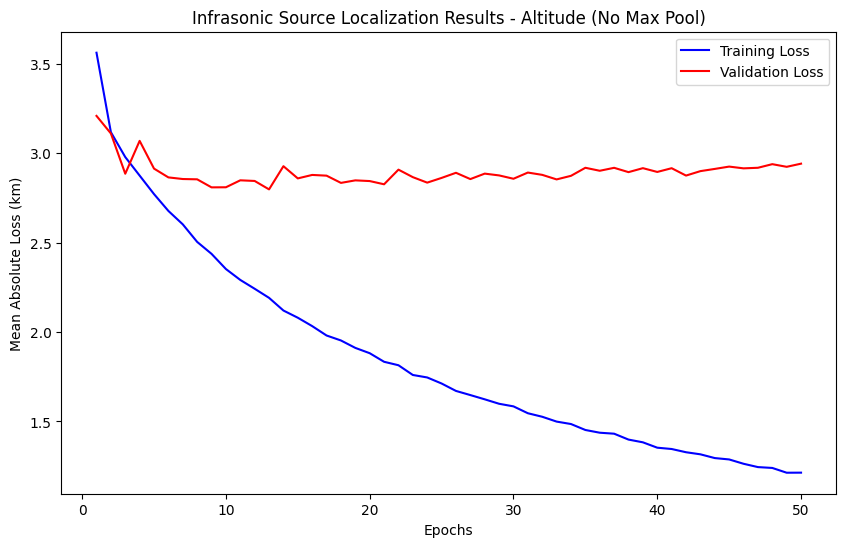

In [11]:
# Extract loss values
train_loss5 = history5.history['mean_absolute_error']
val_loss5 = history5.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss5) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss5, 'b-', label='Training Loss')
plt.plot(epochs, val_loss5, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Altitude (No Max Pool)')
plt.legend()

plt.savefig("Model_Altitude_NoMaxPool.png")

plt.show()

In [13]:
pd.DataFrame(train_loss5).to_csv("altitude_nomaxpool_train_loss")
pd.DataFrame(val_loss5).to_csv("altitude_nomaxpool_val_loss")

In [5]:
model6 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model6.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 64)             320       ['input_2[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4096, 64)             16448     ['conv1d[0][0]']              
                                                                                                  
 input_1 (InputLayer)        [(None, 51, 1)]              0         []                            
                                                                                            

In [6]:
numEpochs = 50
size = 64

history6 = model6.fit(
    [atmo_train, fft_train], distance_train,
    validation_data=([atmo_val, fft_val], distance_val),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model6.save("distance_model_nomaxpool.h5")

Epoch 1/50
1092/1092 [==============================] - 57s 51ms/step - loss: 14016.3408 - mean_absolute_error: 83.3410 - val_loss: 8901.1504 - val_mean_absolute_error: 66.4437
Epoch 2/50
1092/1092 [==============================] - 56s 51ms/step - loss: 7933.1890 - mean_absolute_error: 61.0770 - val_loss: 7459.3174 - val_mean_absolute_error: 58.0882
Epoch 3/50
1092/1092 [==============================] - 56s 51ms/step - loss: 6785.6782 - mean_absolute_error: 54.9082 - val_loss: 6456.6089 - val_mean_absolute_error: 54.2002
Epoch 4/50
1092/1092 [==============================] - 56s 51ms/step - loss: 5984.3374 - mean_absolute_error: 50.6333 - val_loss: 7217.9863 - val_mean_absolute_error: 57.3716
Epoch 5/50
1092/1092 [==============================] - 56s 51ms/step - loss: 5435.2896 - mean_absolute_error: 47.6607 - val_loss: 5762.5986 - val_mean_absolute_error: 45.6685
Epoch 6/50
1092/1092 [==============================] - 56s 51ms/step - loss: 5081.4341 - mean_absolute_error: 45.8209 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


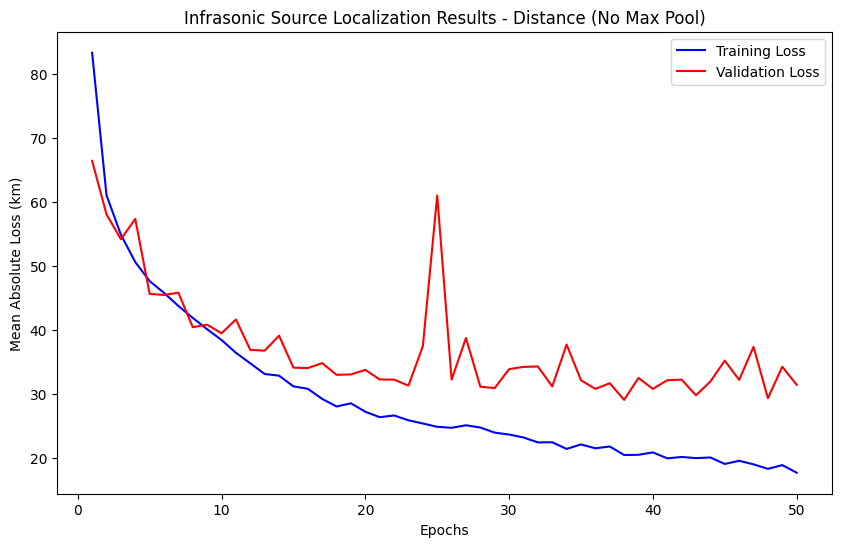

In [7]:
# Extract loss values
train_loss6 = history6.history['mean_absolute_error']
val_loss6 = history6.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss6) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss6, 'b-', label='Training Loss')
plt.plot(epochs, val_loss6, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Distance (No Max Pool)')
plt.legend()

plt.savefig("Model_Distance_NoMaxPool.png")

plt.show()

In [8]:
pd.DataFrame(train_loss6).to_csv("distance_nomaxpool_train_loss")
pd.DataFrame(val_loss6).to_csv("distance_nomaxpool_val_loss")